In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from sklearn import datasets

In [3]:
device = torch.device("cpu")

## 2D regression dataset

In [4]:
num_points = 100
# X1 = np.linspace(-2.5, 1.9, num_points)
X1 = np.linspace(-2.5, 2.5, num_points)
X2 = np.linspace(-2.5, 3, num_points)
# X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)

Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
# Y = np.sqrt(X1**2 + X2**2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

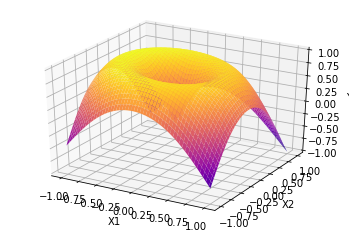

In [5]:
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)
y = Y.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

## Making of matrix factorized layer

In [6]:
class PairFactorizedWeight(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.num_factors = int(np.log2(dim))
        self.pair_indices = [self.get_pair_indices(dim, i+1) for i in range(self.num_factors)]
        self.pair_indices = [tuple(ind.t()) for ind in self.pair_indices]
        
        self.weights = []
        for _ in range(self.num_factors):
            w = nn.Parameter(torch.randn(dim*2))
            self.weights.append(w)
        self.weights = nn.ParameterList(self.weights)
#         self.zero_mat = torch.zeros(dim, dim)
        self.W = torch.eye(self.dim)
        
    def forward(self, x):
        W = self.W
        for pi, w in zip(self.pair_indices, self.weights):
            zero_mat = torch.zeros(self.dim, self.dim)
            zero_mat[pi] = w
            W = W@zero_mat
        return x@W

    def get_pair_indices(self, dim, step=1):
        assert 2**int(np.log2(dim)) == dim , "The dim must be power of 2"
        assert isinstance(step, int), "Step must be integer"

        blocks = (2**step)
        range_ = dim//blocks
        adder_ = torch.arange(0, range_)*blocks

        pairs_ = torch.Tensor([0, blocks//2])
        repeat_ = torch.arange(0, blocks//2).reshape(-1,1)

        block_map = (pairs_+repeat_).reshape(-1)
        reorder_for_pair = (block_map+adder_.reshape(-1,1)).reshape(-1)
        indx = reorder_for_pair.type(torch.long)
        indx = indx.reshape(-1, 2)

        map_idx = []
        for idx in indx:
            map_idx.append((idx[0], idx[0]))
            map_idx.append((idx[0], idx[1]))        
            map_idx.append((idx[1], idx[0]))        
            map_idx.append((idx[1], idx[1]))        
        map_idx = torch.LongTensor(map_idx)
        return map_idx

In [7]:
rfW = PairFactorizedWeight(8)

In [8]:
param_count = sum([torch.numel(p) for p in rfW.parameters()])
param_count

48

In [9]:
8*8/param_count

1.3333333333333333

In [10]:
class FactorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.la1 = nn.Linear(2, 8)
        self.la2 = PairFactorizedWeight(8)
        self.bn2 = nn.BatchNorm1d(8)
        self.la3 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = self.la1(x)
#         x = torch.relu(x)
        x = self.bn2(self.la2(x))
        x = torch.relu(x)
        x = self.la3(x)
        return x

In [11]:
model = FactorNet()

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [13]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

hardness = 0
for epoch in range(10000):

    yout = model(xx)
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
#         fig = plt.figure(figsize=(9,8))
#         ax = fig.gca(projection='3d')

        error = float(loss)
        print(f'Epoch:{epoch} | Error:{error}')
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        yout_ = yout.data.reshape(Y.shape)
        ax.scatter(X1, X2, yout_, color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
#         plt.show()

Epoch:0 | Error:0.2617124915122986
Epoch:200 | Error:0.030245497822761536
Epoch:400 | Error:0.011292863637208939
Epoch:600 | Error:0.009864142164587975
Epoch:800 | Error:0.008691114373505116
Epoch:1000 | Error:0.007727130316197872
Epoch:1200 | Error:0.006997744552791119
Epoch:1400 | Error:0.006813404615968466
Epoch:1600 | Error:0.006507452577352524
Epoch:1800 | Error:0.006431542802602053
Epoch:2000 | Error:0.006400170736014843
Epoch:2200 | Error:0.006399704609066248
Epoch:2400 | Error:0.006385587155818939
Epoch:2600 | Error:0.006388500332832336
Epoch:2800 | Error:0.006393568590283394
Epoch:3000 | Error:0.00643099145963788
Epoch:3200 | Error:0.006378378253430128
Epoch:3400 | Error:0.0063732392154634


TclError: invalid command name "."

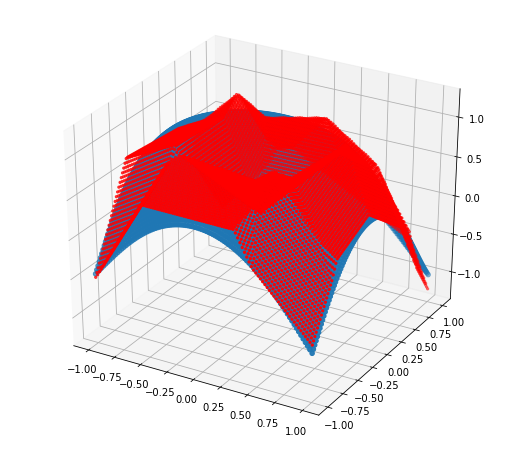

In [14]:
%matplotlib inline
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
plt.show()

In [15]:
## Approximate Weight By multiple factorized weight

In [16]:
a = torch.randn(5, 5)
a

tensor([[ 0.6673, -1.0101, -0.2841, -0.3908,  0.0968],
        [-0.4922, -0.1767,  0.6872, -0.0528,  0.4148],
        [-1.3071,  1.1761, -0.4742,  0.8959, -0.2966],
        [-0.3654, -0.0741, -0.0302, -1.5784, -0.6719],
        [ 0.2074,  0.3742, -0.8687,  1.5439,  0.6947]])

In [17]:
torch.eye(5)@a

tensor([[ 0.6673, -1.0101, -0.2841, -0.3908,  0.0968],
        [-0.4922, -0.1767,  0.6872, -0.0528,  0.4148],
        [-1.3071,  1.1761, -0.4742,  0.8959, -0.2966],
        [-0.3654, -0.0741, -0.0302, -1.5784, -0.6719],
        [ 0.2074,  0.3742, -0.8687,  1.5439,  0.6947]])

### approximating a random matrix

In [23]:
P = 2**3
A = torch.randn(P, P)
A.abs_()

tensor([[9.7087e-01, 3.4374e-01, 1.2005e-01, 5.0448e-01, 2.1107e+00, 1.2798e+00,
         5.8315e-01, 3.8595e-01],
        [7.9491e-01, 1.3027e+00, 1.7166e+00, 6.3909e-01, 2.4826e-01, 9.2222e-01,
         1.8374e-01, 1.8824e+00],
        [3.1501e-01, 4.1503e-01, 1.0186e-01, 1.3927e+00, 6.1836e-01, 4.3963e-01,
         1.7225e-01, 9.3593e-01],
        [6.7294e-01, 1.3181e+00, 7.2917e-01, 1.1695e+00, 9.2887e-02, 4.0316e-02,
         1.4534e-01, 1.7636e-01],
        [7.2048e-01, 6.0856e-01, 4.8403e-02, 5.1345e-02, 1.1891e-03, 8.5137e-01,
         3.5129e-02, 1.5880e+00],
        [1.0309e+00, 8.2272e-01, 3.2244e-01, 3.5941e-01, 5.7892e-03, 4.0809e-01,
         1.4721e+00, 6.7582e-01],
        [9.7763e-01, 5.5178e-01, 1.3692e-01, 1.0573e+00, 2.5541e-01, 1.1443e+00,
         3.0769e-01, 1.9933e+00],
        [9.1276e-01, 1.9130e+00, 4.5257e-02, 6.4153e-01, 2.6704e-01, 1.2636e-01,
         1.0819e+00, 1.1203e+00]])

In [24]:
layers = [PairFactorizedWeight(P) for _ in range(1)]
net = nn.Sequential(*layers)

In [25]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

mse = nn.MSELoss()

In [26]:
### forward propagation
for i in range(10000):
    W = net(torch.eye(P))
    loss = mse(W,A)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%1000 == 0:
        print(f"The MSE loss is : {float(mse(W,A))}")

The MSE loss is : 3.262380838394165
The MSE loss is : 0.6454951763153076
The MSE loss is : 0.2862173616886139
The MSE loss is : 0.19580602645874023
The MSE loss is : 0.16736726462841034
The MSE loss is : 0.15153411030769348
The MSE loss is : 0.14697661995887756
The MSE loss is : 0.14697575569152832
The MSE loss is : 0.14697575569152832
The MSE loss is : 0.14697575569152832


In [27]:
### do this for different factors

for num_l in range(1, 4):
    print("Approximating using N =",num_l)
    
    layers = [PairFactorizedWeight(P) for _ in range(num_l)]
    net = nn.Sequential(*layers)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    # optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
    mse = nn.MSELoss()

    ### forward propagation
    prev_mse = 9e9
    for i in range(100000):
        W = net(torch.eye(P))
        loss = mse(W,A)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%1000 == 0:
            cur_mse = float(mse(W,A))
            print(f"Step: {i} | The MSE loss is : {cur_mse}")
            if abs(prev_mse - cur_mse) < 1e-6:
                print("Close Enough")
                break
            prev_mse = cur_mse
    print("Det A, W =", torch.det(A.data), torch.det(W.data))
    print("=========================")

Approximating using N = 1
Step: 0 | The MSE loss is : 1.184406042098999
Step: 1000 | The MSE loss is : 0.41647350788116455
Step: 2000 | The MSE loss is : 0.33421820402145386
Step: 3000 | The MSE loss is : 0.25057774782180786
Step: 4000 | The MSE loss is : 0.23702223598957062
Step: 5000 | The MSE loss is : 0.1488436758518219
Step: 6000 | The MSE loss is : 0.14697575569152832
Step: 7000 | The MSE loss is : 0.14697574079036713
Close Enough
Det A, W = tensor(-0.1182) tensor(5.2242e-05)
Approximating using N = 2
Step: 0 | The MSE loss is : 3.8266992568969727
Step: 1000 | The MSE loss is : 0.2661435008049011
Step: 2000 | The MSE loss is : 0.08992798626422882
Step: 3000 | The MSE loss is : 0.061327751725912094
Step: 4000 | The MSE loss is : 0.04730001837015152
Step: 5000 | The MSE loss is : 0.03451012447476387
Step: 6000 | The MSE loss is : 0.031029127538204193
Step: 7000 | The MSE loss is : 0.025193627923727036
Step: 8000 | The MSE loss is : 0.020390741527080536
Step: 9000 | The MSE loss is 

In [ ]:
## using random matrix
Approximating using N = 1
Step: 6000 | The MSE loss is : 0.2620971202850342
Close Enough
Det A, W = tensor(-71.0458) tensor(-5.7656)
=========================
Approximating using N = 2
Step: 59000 | The MSE loss is : 0.013522385619580746
Close Enough
Det A, W = tensor(-71.0458) tensor(-16.4772)
=========================
Approximating using N = 3
Step: 81000 | The MSE loss is : 0.0001587876322446391
Close Enough
Det A, W = tensor(-71.0458) tensor(-18.2761)
=========================

In [ ]:
## using non-negative matrix
Step: 7000 | The MSE loss is : 0.14697574079036713
Close Enough
Det A, W = tensor(-0.1182) tensor(5.2242e-05)
=========================
Approximating using N = 2
Step: 31000 | The MSE loss is : 0.007717188447713852
Close Enough
Det A, W = tensor(-0.1182) tensor(1.6129)
=========================
Approximating using N = 3
Step: 99000 | The MSE loss is : 0.0007677526446059346
Det A, W = tensor(-0.1182) tensor(-0.6321)
=========================


In [34]:
W-A

tensor([[ 1.6715e-02,  5.5310e-03, -3.5526e-02, -1.7322e-02,  1.8324e-02,
          4.1550e-03,  1.4034e-02,  4.1663e-02],
        [-7.7381e-02, -3.2284e-02, -3.2775e-02, -1.6585e-01, -2.2254e-01,
         -1.0678e-01, -9.9004e-02, -1.0857e-01],
        [-3.6056e-02, -1.3609e-02,  3.7291e-02, -8.7702e-03, -8.3602e-03,
         -2.0736e-04, -1.3605e-02, -2.1013e-02],
        [-2.8845e-02, -1.6526e-02, -2.4403e-02, -7.0076e-02, -1.1064e-01,
         -4.9361e-02, -4.0607e-02, -4.9573e-02],
        [-1.0477e-02, -1.9488e-03, -1.0880e-01, -3.6331e-04,  7.7908e-03,
          2.1681e-03,  3.0376e-02, -3.1140e-03],
        [-8.8757e-03, -4.4960e-03, -3.4912e-02, -4.1687e-03, -4.4447e-03,
         -2.6135e-03,  7.2311e-03, -4.5155e-03],
        [ 1.1713e-02, -1.4772e-03, -1.2169e-01, -2.6181e-03, -4.9301e-03,
         -2.0238e-03,  1.5595e-02, -1.1163e-02],
        [-4.0603e-03, -8.6498e-04,  1.0876e-01, -1.3111e-02, -6.4915e-03,
         -9.1235e-03, -2.7428e-02, -2.4644e-03]], grad_fn=<SubBac

In [33]:
torch.log10((W-A).abs())

tensor([[-1.7769, -2.2572, -1.4495, -1.7614, -1.7370, -2.3814, -1.8528, -1.3802],
        [-1.1114, -1.4910, -1.4845, -0.7803, -0.6526, -0.9715, -1.0043, -0.9643],
        [-1.4430, -1.8662, -1.4284, -2.0570, -2.0778, -3.6833, -1.8663, -1.6775],
        [-1.5399, -1.7818, -1.6126, -1.1544, -0.9561, -1.3066, -1.3914, -1.3048],
        [-1.9798, -2.7102, -0.9634, -3.4397, -2.1084, -2.6639, -1.5175, -2.5067],
        [-2.0518, -2.3472, -1.4570, -2.3800, -2.3522, -2.5828, -2.1408, -2.3453],
        [-1.9313, -2.8306, -0.9147, -2.5820, -2.3071, -2.6938, -1.8070, -1.9522],
        [-2.3914, -3.0630, -0.9635, -1.8824, -2.1877, -2.0398, -1.5618, -2.6083]],
       grad_fn=<Log10Backward>)